# 1) Veri Keşfi

In [1]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import os
from pathlib import Path

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


## 1.1) Veri Yükleme

**Tüm veri**

WorkinTech'ın mühendislik ekibi 2009'dan beri tüm taksi yolculuğu geçmişini devasa bir Big Query tablosunda `mlops.mlops_all` saklar. 

**Eğitim aşaması verisi**

- Eğitim aşaması `2015-01-01` tarihinde gerçekleşir. Modelimizi eğitmek için bu tarihten sonraki verilere erişemeyiz
- Veri bilimcinin notebook'u burada **200k rastgele örneklenmiş alt küme** üzerinde bir ML modeli eğitir (böylece her şey Veri Bilimcinin laptopunda RAM belleğine sığar)
- WorkinTech'in veri mühendisliği ekibi bu `mlops_all` tablosundan `raw_200k` adlı bir `materialized view` oluşturmuş ve DataScientist'e eğitimi için okuma erişimi vermiştir.

In [5]:
LOCAL_DATA_PATH = Path('~').joinpath(".workintech", "mlops", "data").expanduser()
GCP_PROJECT = "seraphic-alloy-473611-c7"
GCP_PROJECT = "seraphic-alloy-473611-c7"   # senin projen (billing & quota için)
BQ_SOURCE_PROJECT = "data-analytics-469406"  # dataset'in bulunduğu proje
BQ_DATASET = "mlops"
DATA_SIZE = "all"
MIN_DATE = '2009-01-01'
MAX_DATE = '2015-01-01'
COLUMN_NAMES_RAW = ('fare_amount',	'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count')

**Aşağıda `GCP_PROJECT`'inizi doldurun 👇**, Daha sonra geçmiş verileri (2015 öncesi) sorgulayalım, tarihe göre sıralanmış (böylece eğitim/test ayrımını kronolojik olarak daha kolay yapabiliriz)!


In [8]:
query = f"""
SELECT {", ".join(COLUMN_NAMES_RAW)}
FROM `{BQ_SOURCE_PROJECT}.{BQ_DATASET}.{BQ_DATASET}_{DATA_SIZE}`
WHERE pickup_datetime BETWEEN '{MIN_DATE}' AND '{MAX_DATE}'
ORDER BY pickup_datetime
"""
print(query)


SELECT fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count
FROM `data-analytics-469406.mlops.mlops_all`
WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-01-01'
ORDER BY pickup_datetime



BigQuery çağrısını yalnızca dosya yerel olarak mevcut değilse yap.  
Aksi halde, her notebook çalıştırmasında BigQuery'yi çağırmaktan kaçınmak için yerel olarak CSV olarak sakla.

In [9]:
data_query_cache_path = Path(LOCAL_DATA_PATH).joinpath("raw", f"query_{MIN_DATE}_{MAX_DATE}_{DATA_SIZE}.csv")

if data_query_cache_path.is_file():
    print("load local file...")
    df = pd.read_csv(data_query_cache_path, parse_dates=['pickup_datetime'])

else:
    print("Querying Big Query server...")
    from google.cloud import bigquery

    client = bigquery.Client(project=GCP_PROJECT)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()

    df.to_csv(data_query_cache_path, header=True, index=False)


Querying Big Query server...


In [10]:
df


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.20,2009-01-01 01:14:44+00:00,-73.982410,40.782397,-73.978177,40.783295,1
1,11.80,2009-01-01 03:51:05+00:00,-74.006797,40.716359,-73.978616,40.752433,2
2,26.60,2009-01-01 04:23:00+00:00,-73.982930,40.742167,-73.896904,40.843012,1
3,19.80,2009-01-01 04:49:52+00:00,-73.983822,40.729471,-73.982300,40.776622,2
4,3.40,2009-01-01 05:04:41+00:00,-74.013008,40.706021,-74.012851,40.702645,1
...,...,...,...,...,...,...,...
90738,14.50,2014-12-31 22:08:00+00:00,-73.980395,40.742585,-73.994602,40.769627,1
90739,9.50,2014-12-31 22:19:11+00:00,-73.962421,40.794752,-73.940646,40.814270,2
90740,74.16,2014-12-31 22:26:27+00:00,-73.783610,40.648637,-74.091878,40.626073,2
90741,8.50,2014-12-31 22:29:09+00:00,-73.995097,40.752067,-73.981982,40.766362,1


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90743 entries, 0 to 90742
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        90743 non-null  float64            
 1   pickup_datetime    90743 non-null  datetime64[ns, UTC]
 2   pickup_longitude   90743 non-null  float64            
 3   pickup_latitude    90743 non-null  float64            
 4   dropoff_longitude  90743 non-null  float64            
 5   dropoff_latitude   90743 non-null  float64            
 6   passenger_count    90743 non-null  Int64              
dtypes: Int64(1), datetime64[ns, UTC](1), float64(5)
memory usage: 4.9 MB


### 1.1.1) Veri Sıkıştırma

DataFrame'imizi sayısal `dtypes` değerlerini düşürerek sıkıştıralım
- `float64`'den `float32`'ye
- `int64`'den `int8`'e

Bunu yapmak için sütunlarında döngü yaparız ve her biri için [`pd.to_numeric`](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) kullanarak `dtypes` değerini mümkün olduğunca düşürürüz

**💡 1) ML Ops Bellek Optimizasyonu `dtype` sıkıştırma hakkında daha fazla bilgi okuyun**

**💡 2) Daha sonra, aşağıdaki kodu anlayın ve çalıştırın**

In [12]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')

    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df


In [13]:
df = compress(df, verbose=True)
df.head(1)


old dataframe size:  4.93 MB
optimized size by 47.0 %
new DataFrame size:  2.6  MB


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.2,2009-01-01 01:14:44+00:00,-73.982407,40.782398,-73.97818,40.783295,1


Optimize edilmiş dtypes'ları kontrol edelim

In [14]:
df.dtypes


fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                     Int8
dtype: object

💡 Int8 bazı bilimsel kütüphaneler için biraz çok küçük, int16 kullanalım

In [15]:
df.passenger_count = df.passenger_count.astype("int16")


💡 Next time, we can force dtypes directly **at loading time** as follow:

```python
query_job = client.query(query)
result = query_job.result() 
df = result.to_dataframe(dtypes=DTYPES_RAW)
```

In [16]:
DTYPES_RAW = {
    "key": "datetime64[ns, UTC]",
    "fare_amount": "float32",
    "pickup_datetime": "datetime64[ns, UTC]",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count": "int16"
}


## 1.2) Veri Temizleme

In [17]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,90743.000000,90743.000000,90743.000000,90743.000000,90743.000000,90743.000000
mean,11.184034,-72.515381,39.943375,-72.532669,39.941231,1.683149
std,9.550824,10.696279,8.880565,12.055413,8.878703,1.303741
min,-2.500000,-736.583313,-74.009773,-1749.704590,-74.015160,0.000000
25%,6.000000,-73.992065,40.735081,-73.991379,40.734219,1.000000
50%,8.500000,-73.981850,40.752686,-73.980202,40.753307,1.000000
75%,12.500000,-73.967209,40.767073,-73.963799,40.767990,2.000000
max,208.000000,169.972763,1963.515869,169.972763,1963.515869,6.000000


In [18]:
df.shape


(90743, 7)

gereksiz satırları kaldır

In [19]:
df = df.drop_duplicates()
df.shape


(90743, 7)

Hatalı işlemleri kaldır

In [20]:
df = df.dropna(how='any', axis=0)
print(df.shape)
df = df[df.passenger_count > 0]
df = df[df.fare_amount > 0]
print(df.shape)


(90743, 7)
(90422, 7)


Coğrafi olarak alakasız işlemleri (satırları) kaldır

(-0.5, 1751.5, 1537.5, -0.5)

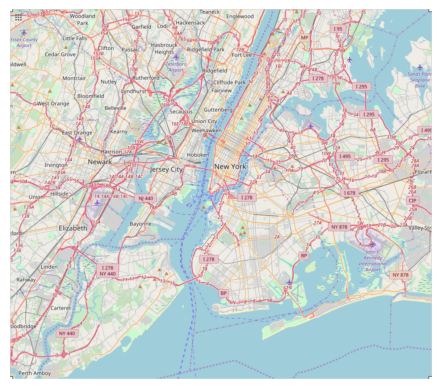

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

bounding_boxes = (-74.3, -73.7, 40.5, 40.9)

nyc_map = np.array(
    Image.open("../nyc_-74.3_-73.7_40.5_40.9.png")
)

plt.imshow(nyc_map)
plt.axis("off")

In [28]:
df = df[df["pickup_latitude"].between(left=40.5, right=40.9)]
df = df[df["dropoff_latitude"].between(left=40.5, right=40.9)]
df = df[df["pickup_longitude"].between(left=-74.3, right=-73.7)]
df = df[df["dropoff_longitude"].between(left=-74.3, right=-73.7)]


In [29]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,88381.000000,88381.000000,88381.000000,88381.000000,88381.000000,88381.000000
mean,11.128640,-73.975761,40.750935,-73.974655,40.751213,1.688689
std,9.218863,0.033885,0.026704,0.033909,0.030540,1.301394
min,2.500000,-74.244141,40.502598,-74.275803,40.501408,1.000000
25%,6.000000,-73.992287,40.736656,-73.991570,40.735806,1.000000
50%,8.500000,-73.982124,40.753403,-73.980698,40.753948,1.000000
75%,12.500000,-73.968452,40.767433,-73.965591,40.768276,2.000000
max,158.250000,-73.702583,40.893471,-73.700836,40.898937,6.000000


In [30]:
# Let's cap training set to reasonable values
df = df[df.fare_amount < 400]
df = df[df.passenger_count < 8]


In [31]:
df


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.200000,2009-01-01 01:14:44+00:00,-73.982407,40.782398,-73.978180,40.783295,1
1,11.800000,2009-01-01 03:51:05+00:00,-74.006798,40.716358,-73.978615,40.752434,2
2,26.600000,2009-01-01 04:23:00+00:00,-73.982933,40.742168,-73.896904,40.843014,1
3,19.799999,2009-01-01 04:49:52+00:00,-73.983826,40.729469,-73.982300,40.776623,2
4,3.400000,2009-01-01 05:04:41+00:00,-74.013008,40.706020,-74.012848,40.702644,1
...,...,...,...,...,...,...,...
90738,14.500000,2014-12-31 22:08:00+00:00,-73.980392,40.742584,-73.994598,40.769627,1
90739,9.500000,2014-12-31 22:19:11+00:00,-73.962418,40.794750,-73.940643,40.814270,2
90740,74.160004,2014-12-31 22:26:27+00:00,-73.783607,40.648636,-74.091881,40.626072,2
90741,8.500000,2014-12-31 22:29:09+00:00,-73.995094,40.752068,-73.981979,40.766361,1


## 1.3) Veri Görselleştirme

Text(0.5, 1.0, 'Histogram')

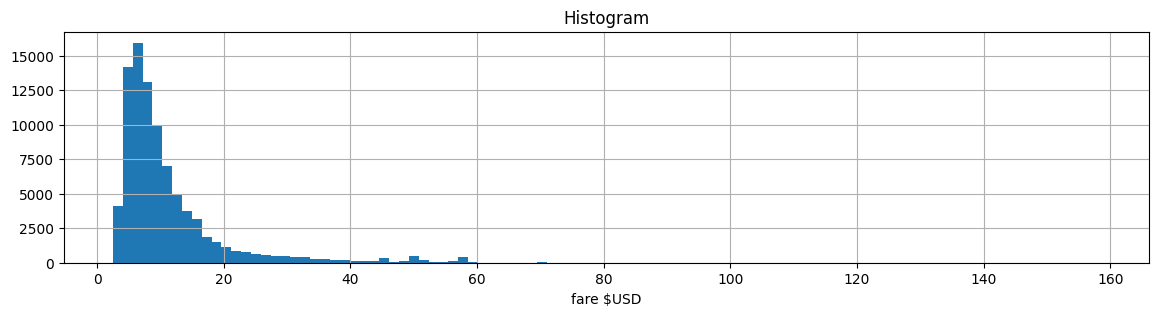

In [32]:
# Plot histogram of fare
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')


In [33]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))

    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='red', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='blue', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)


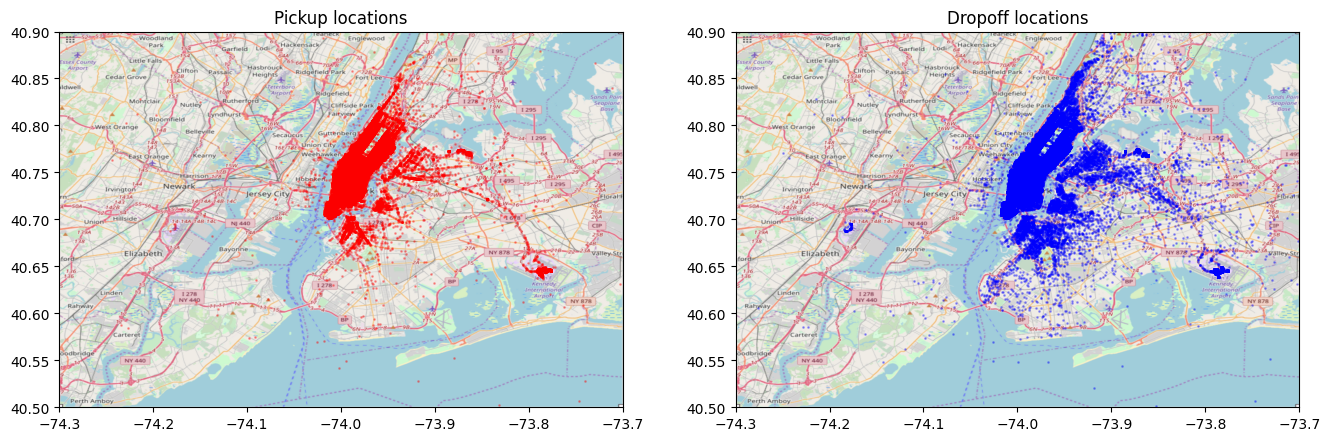

In [34]:
# Plot training data on map
plot_on_map(df, bounding_boxes, nyc_map, s=1, alpha=0.3)


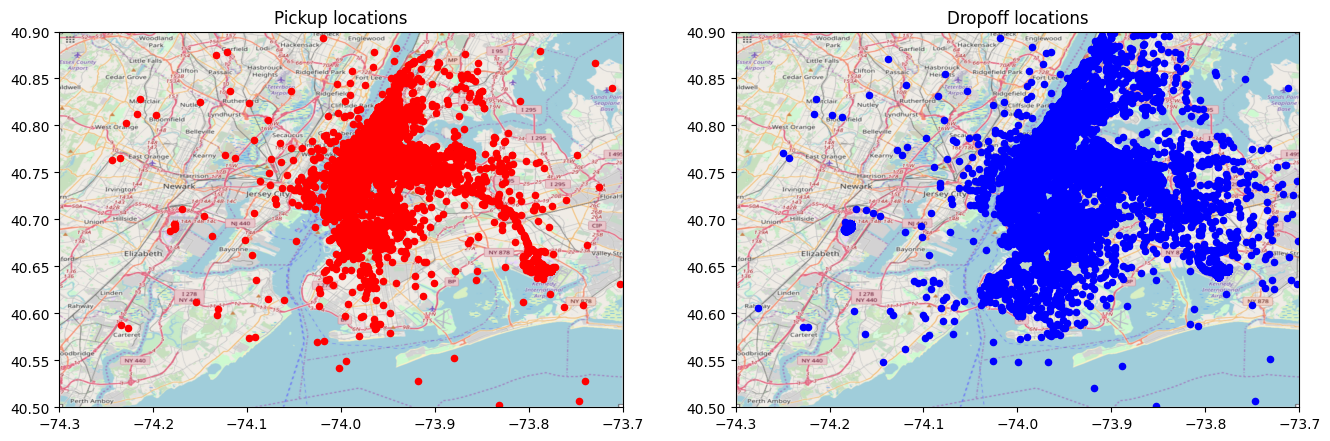

In [35]:
plot_on_map(df, bounding_boxes, nyc_map, s=20, alpha=1.0)


In [36]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    def select_within_boundingbox(df, BB):
        return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
            (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
            (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
            (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c="red", s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c="blue", s=0.01, alpha=0.5)


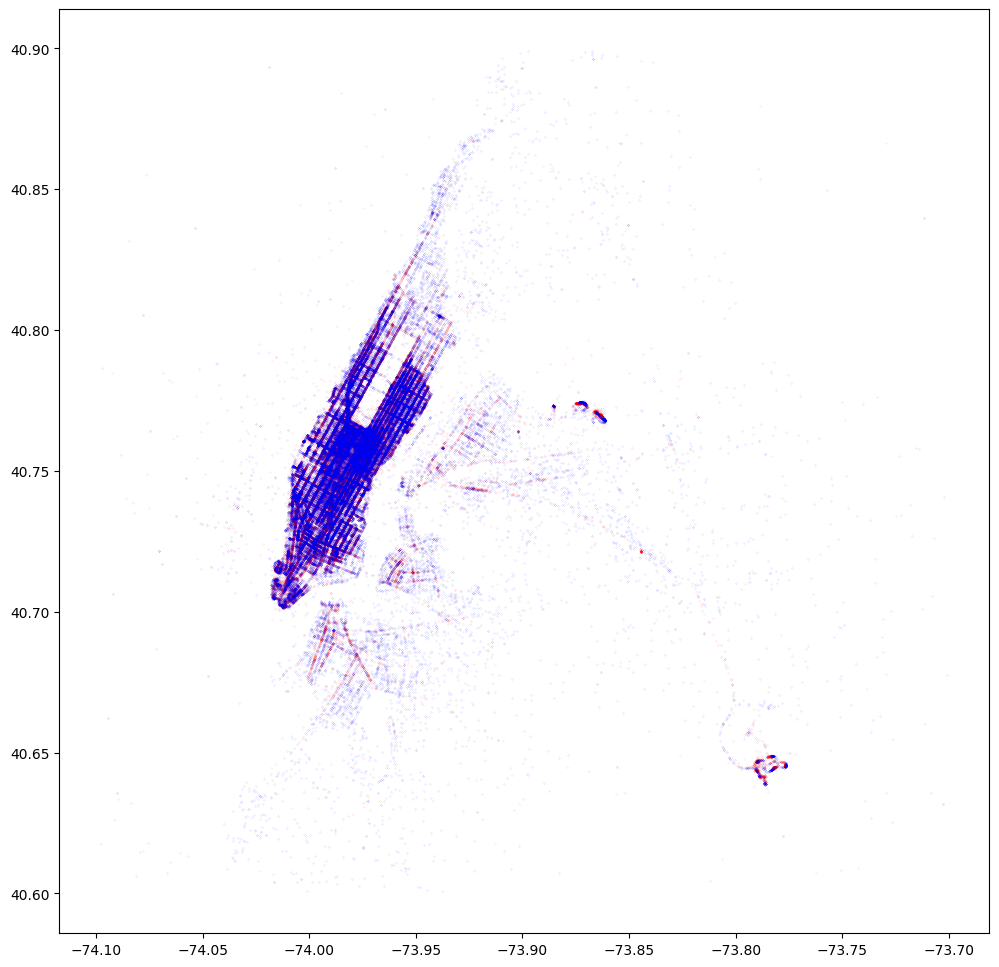

In [37]:
plot_hires(df, (-74.1, -73.7, 40.6, 40.9))


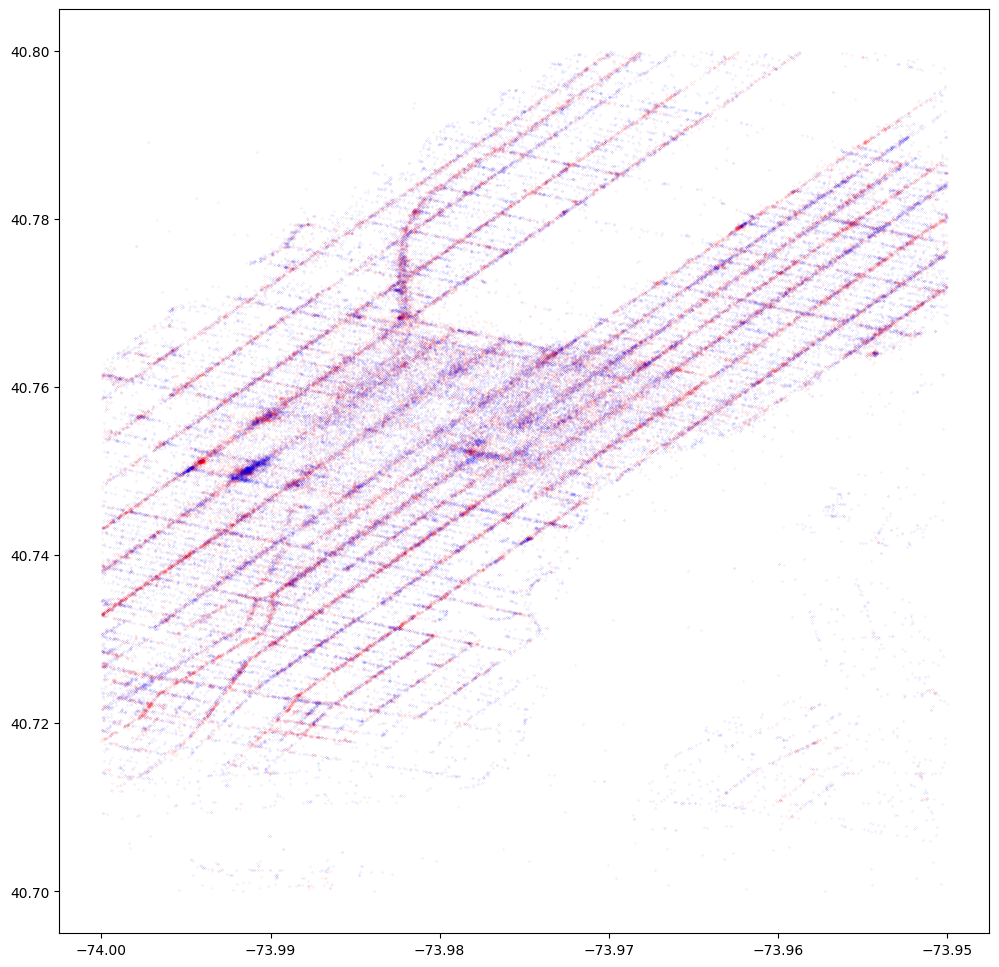

In [38]:
plot_hires(df, (-74, -73.95, 40.7, 40.8))


### 1.4) Temel Skor - Ön Sezgiler

Bir temel model en azından en belirgin özelliği dikkate almalıdır: `pickup` ve `dropoff` arasındaki mesafe.

Doğru mesafe metriği uygun şekilde "Manhattan mesafesi" (L1 mesafesi) olarak adlandırılır ve iki nokta arasındaki yatay ve dikey mesafelerin toplamını hesaplar, köşegen (Öklid, L2) mesafesi yerine.

In [39]:
import math

def manhattan_distance(start_lat: float, start_lon: float, end_lat: float, end_lon: float) -> float:
    """
    Calculate the Manhattan distance between in km two points on the earth (specified in decimal degrees).
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = math.radians(start_lat), math.radians(start_lon)
    lat_2_rad, lon_2_rad = math.radians(end_lat), math.radians(end_lon)

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = abs(dlon_rad) + abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    return manhattan_km


In [40]:
%%time
df.apply(lambda row: manhattan_distance(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)


CPU times: user 1.15 s, sys: 7.1 ms, total: 1.16 s
Wall time: 1.25 s


0         0.569667
1         7.145228
2        20.779484
3         5.412897
4         0.393210
           ...    
90738     4.586604
90739     4.591694
90740    36.787424
90741     3.047697
90742     3.395521
Length: 88381, dtype: float64

☝️ Aşağıdaki kod biraz zaman alır ve optimize edilmemiştir.

Bir DataFrame üzerinde satır satır bir eşleme fonksiyonu uygulamak çok kötü bir mühendislik pratiğidir, çünkü DataFrame'ler bellekte "sütun sütun" saklanır. "Column-major" veri saklama formatları hakkında konuşuyoruz. 

`df.apply(..., axis=1)` bir python `for` döngüsüne eşdeğerdir ve NumPy'nin vektörleştirilmiş işlemlerini kullanmaz.

👇 Bunun yerine kodumuzu vektörleştirelim! Birkaç yüz faktörle iyileşmeyi fark edin 💪

In [41]:
def manhattan_distance_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the Manhattan distance in km between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    return manhattan_km


In [42]:
%%time
manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")


CPU times: user 3.29 ms, sys: 617 μs, total: 3.91 ms
Wall time: 3.66 ms


0         0.569232
1         7.145590
2        20.780197
3         5.412451
4         0.393412
           ...    
90738     4.586134
90739     4.591830
90740    36.786667
90741     3.047423
90742     3.396025
Length: 88381, dtype: float32

Text(0.5, 1.0, 'distance (km)')

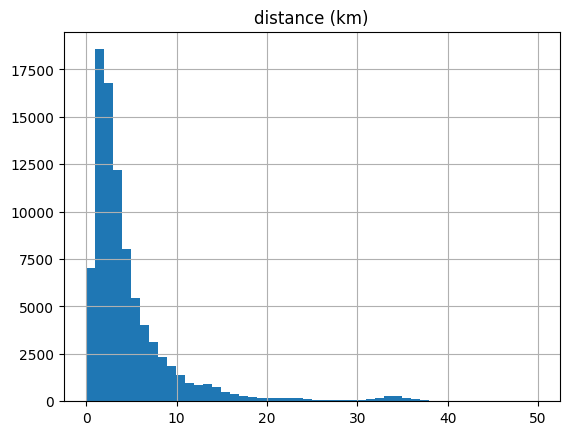

In [43]:
df['distance'] = manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")
df['distance'].hist(bins=50)
plt.title("distance (km)")


Manuel olarak eklediğimiz `distance` sütununu düşürelim ve şimdi gerçek bir ön işleme pipeline'ı oluşturalım

In [44]:
df = df.drop(columns=['distance'])
df.shape


(88381, 7)

# 2) Eğitim/Doğrulama/Test Ayrımı

🚨 Zaman damgalı verilerle uğraşıyoruz:
- Eğitim/doğrulama/test ayrımını **kronolojik** bir şekilde yapmak önemlidir.
- Çok uzun doğrulama veya test kümelerini tutmak istemeyiz: gerçek hayatta makroekonomik koşullar hızla değişiyor!
- `split_ratio` ne kadar küçük olursa, modelimizi o kadar sık yeniden eğitmemiz gerekecek
- 6 yıllık bir veri kümesiyle, doğrulama için 1 ay ilerisi, test için 1 ay ilerisi tutmak tamamen uygun
- Üretimde, bu model performansımızın gelecekte 1 aydan fazla uzanmasına güvenmememiz gerektiği anlamına gelir

In [45]:
split_ratio = 0.02 # ~1 month for val, ~1 month for test

test_length = int(len(df) * split_ratio)
val_length = int((len(df)-test_length) * split_ratio)
train_length = len(df) - val_length - test_length

df_train = df.iloc[:train_length, :].sample(frac=1) # Shuffle datasets to improve training
df_val = df.iloc[train_length: train_length + val_length, :].sample(frac=1)
df_test = df.iloc[train_length+val_length:, :].sample(frac=1)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

assert len(df_train) + len(df_val) + len(df_test) == len(df)


(84882, 7)
(1732, 7)
(1767, 7)


In [46]:
print(df_train.pickup_datetime.min())
print(df_train.pickup_datetime.max())
print('---')
print(df_val.pickup_datetime.min())
print(df_val.pickup_datetime.max())
print('---')
print(df_test.pickup_datetime.min())
print(df_test.pickup_datetime.max())


2009-01-01 01:14:44+00:00
2014-09-29 21:52:00+00:00
---
2014-09-30 00:09:00+00:00
2014-11-14 01:10:00+00:00
---
2014-11-14 02:00:00+00:00
2014-12-31 23:49:25+00:00


In [47]:

X = df.drop("fare_amount", axis=1)
y = df[["fare_amount"]]

X_train = df_train.drop("fare_amount", axis=1)
y_train = df_train[["fare_amount"]]

X_val = df_val.drop("fare_amount", axis=1)
y_val = df_val[["fare_amount"]]

X_test = df_test.drop("fare_amount", axis=1)
y_test = df_test[["fare_amount"]]


### Basit Temel: $price = a * distance + b $

In [48]:
distances_train = np.array(manhattan_distance_vectorized(X_train, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_val = np.array(manhattan_distance_vectorized(X_val, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_test = np.array(manhattan_distance_vectorized(X_test, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))


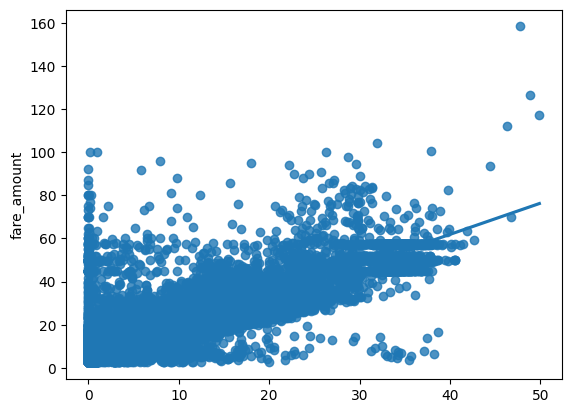

In [49]:
sns.regplot(x=distances_train, y=y_train);


In [50]:
from scipy.stats import pearsonr

pearson, p_value = pearsonr(distances_train, y_train)
print(f'{pearson=}')
print(f'{p_value=}')


pearson=array([0.8636389105299012], dtype=object)
p_value=0.0


In [51]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
baseline_model.fit(distances_train[:, None], y_train)


LinearRegression()

In [52]:
baseline_pred_val = baseline_model.predict(distances_val[:, None])
baseline_pred_test = baseline_model.predict(distances_test[:, None])
baseline_mae_val = np.mean(np.abs(baseline_pred_val - y_val), axis=0)
baseline_mae_test = np.mean(np.abs(baseline_pred_test - y_test), axis=0)

print(f'mean taxifare prices on train set = {round(float(np.mean(y_train, axis=0)),2)} $')
print(f'🎯 baseline MAE on val set = {round(float(baseline_mae_val),2)} $')
print(f'🎯 baseline MAE on test set = {round(float(baseline_mae_test),2)} $')


mean taxifare prices on train set = 11.04 $
🎯 baseline MAE on val set = 2.85 $
🎯 baseline MAE on test set = 2.88 $


# 3) Ön İşleme Pipeline'ı

Bize yalnızca 5 özellik (yolcular + boylam/enlem) ve potansiyel olarak on milyonlarca satır içeren bir veri kümesi veriliyor.

👉 "günün saati" gibi bir sürü "mühendislik" özelliği oluşturmak tamamen mantıklı  
- Yüzlercesi hiçbir problem yaratmaz çünkü büyük sayıda satır modelimizin bu çoklu özelliklerle ilişkili tüm ağırlıkları öğrenmesini sağlayacaktır
- Yoğun, Derin Öğrenme ağı böyle bir durum için çok uygundur

❗️ Aşağıda önerilen ön işlemci **sabit sayıda özellik** (65) çıkarır ve bu **eğitim kümesinden bağımsızdır**. Bunu yüz milyonlarca satıra ölçeklendirirken işe yarayacağını göreceksiniz

## 3.1) Yolcu Ön İşlemcileri

Yolcu sayılarını analiz edelim

In [53]:
df.passenger_count


0        1
1        2
2        1
3        2
4        1
        ..
90738    1
90739    2
90740    2
90741    1
90742    1
Name: passenger_count, Length: 88381, dtype: int16

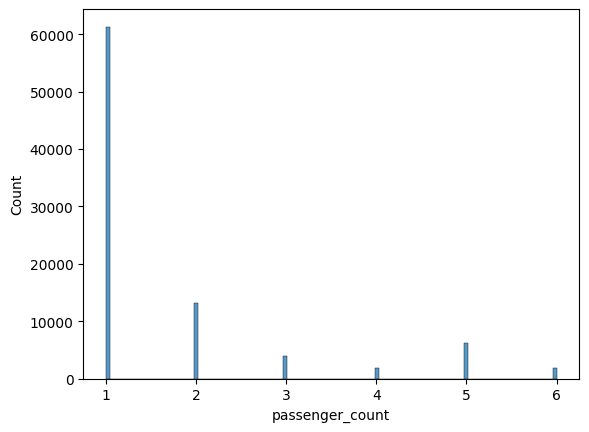

In [54]:
sns.histplot(data=df, x="passenger_count");


In [55]:
# PASSENGER PIPE
p_min = 1.
p_max = 8.
passenger_pipe = FunctionTransformer(lambda p: (p-p_min)/(p_max-p_min))


In [56]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
    ],
)
preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x785a1ce19990>),
                                 ['passenger_count'])])

In [57]:
pd.DataFrame(preprocessor.fit_transform(X_train))


,0
0,0.142857
1,0.571429
2,0.571429
3,0.571429
4,0.000000
...,...
84877,0.428571
84878,0.000000
84879,0.714286
84880,0.000000


## 3.2) Zaman Ön İşlemcisi

`pickup_datetime`'dan ilginç öznitelikleri çıkaralım
- günün saati
- haftanın günü
- yılın ayı
- 2009'dan beri gün sayısı (enflasyon parametrelerini kodlayabilir)

In [58]:
import math

def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    timedelta = (X["pickup_datetime"] - pd.Timestamp('2009-01-01T00:00:00', tz='UTC'))/pd.Timedelta(1,'D')

    pickup_dt = X["pickup_datetime"].dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)

    return np.stack([hour_sin, hour_cos, dow, month, timedelta], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "timedelta"]).head()


,hour_sin,hour_cos,dow,month,timedelta
0,-0.866025,0.500000,2.0,12.0,0.051898
1,-0.500000,0.866025,2.0,12.0,0.160475
2,-0.258819,0.965926,2.0,12.0,0.182639
3,-0.258819,0.965926,2.0,12.0,0.201296
4,0.000000,1.000000,3.0,1.0,0.211586


Daha sonra, tüm 24*7 kategori kombinasyonlarını `X_processed`'da her zaman mevcut olmaya zorlayarak `["haftanın günü", "ay"]`'ı one-hot kodlarız 

(sonunda `X_processed` için sabit bir boyut istediğimizi unutmayın)

In [59]:
time_categories = [
        np.arange(0, 7, 1),  # days of the week from 0 to 6
        np.arange(1, 13, 1)  # months of the year from 1 to 12
    ]

OneHotEncoder(categories=time_categories, sparse_output=False)\
    .fit_transform(X_time_processed[:,[2,3]]) # column index [2,3] for ['dow', 'month'] !


array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

Ve bunu `timedelta` sütununun bir tür "Min-Max" yeniden ölçeklemesi ile birleştirin

In [60]:
print(X_time_processed[:,-1].min())
print(X_time_processed[:,-1].max())


0.05189814814814815
2190.992650462963


In [61]:
timedelta_min = 0
timedelta_max = 2190 # Our model may extend in the future. No big deal if the scaled data extend slightly beyond 1.0


In [62]:
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2, 3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - timedelta_min) / (timedelta_max - timedelta_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
    ],
)

preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x785a1ce19990>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x785a1ce19bd0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(categories=[array([0, 1, 2, 3, 4, 5, 6]),
                                                                                                             array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])],
                                                                                                 handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('functiontransformer',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x785a54b25d80>),
                                                                                   [4])]))]),
                                 ['pickup_datetime'])])

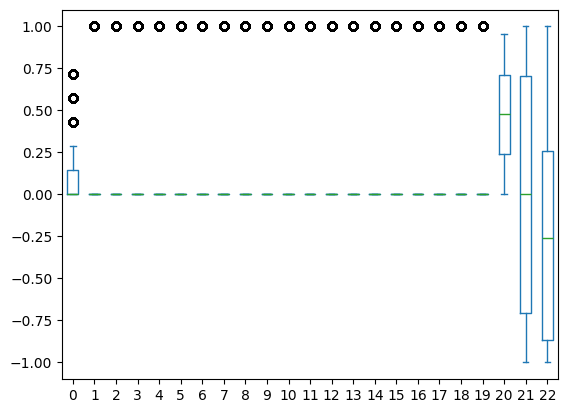

In [63]:
pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');


☝️ Yaklaşık olarak ortalanmış ve ölçeklenmiş 23 özellik

## 3.3) Mesafe Pipeline'ı

Hem haversine hem de Manhattan mesafelerini özellik olarak ekleyelim

In [64]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]


In [65]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and Manhattan distances between two points (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in Km
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius

    return dict(
        haversine = haversine_km,
        manhattan = manhattan_km
    )


In [66]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:
    assert isinstance(X, pd.DataFrame)
    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances


,haversine,manhattan
0,0.369161,0.569232
1,4.661616,7.145590
2,13.349266,20.780197
3,5.244656,5.412451
4,0.375439,0.393412
...,...,...
90738,3.236299,4.586134
90739,2.840849,4.591830
90740,26.132246,36.786667
90741,1.935356,3.047423


In [67]:
dist_min = 0
dist_max = 100


In [68]:
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
    )
distance_pipe


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function transform_lonlat_features at 0x785a19a83010>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function <lambda> at 0x785a19a82ef0>))])

In [69]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x785a1ce19990>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x785a1ce19bd0>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('oneho...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x785a54b25d80>),
                                                                                   [4])]))]),
                                 ['pickup_datetime']),
                                ('dist_preproc',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x785a19a83010>)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function <lambda> at 0x785a19a82ef0>))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

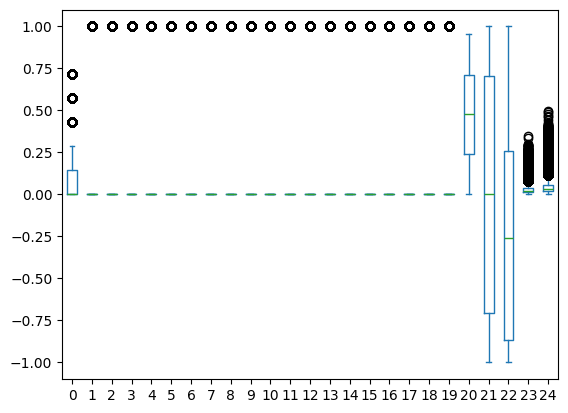

In [70]:
X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');


☝️ Yaklaşık olarak ölçeklenmiş 25 özellik

## 3.4) GeoHasher

Son olarak, **bölgeler** hakkında bilgi ekleyelim! 

Bazıları diğerlerinden daha pahalı olabilir (örn. JFK havalimanı!)

Jeouzaysal bilgiyi _bucketize_ etmek için `pygeohash` kullanacağız

In [71]:
import pygeohash as gh


💡 pygeohash (lat,lon)'u seçilen kesinliklerde jeospacial "kare kovalar"a dönüştürür. Ne kadar çok kesinlik isterseniz, o kadar çok "kova" olasılığı vardır!

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/geohashes.png">

In [72]:
x0 = X_train.iloc[0,:]
(x0.pickup_latitude, x0.pickup_longitude)


(40.747078, -73.97931)

In [73]:
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=3))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=4))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=5))


dr5
dr5r
dr5ru


👇 Bunu TÜM veri setumuze uygulayalım (bu ön işlemenin çok uzun zaman alabileceğini unutmayın!)

In [74]:
def compute_geohash(X:pd.DataFrame, precision:int = 5) -> np.ndarray:
    """
    Add a geohash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]


In [75]:
compute_geohash(X_train)


,geohash_pickup,geohash_dropoff
53627,dr5ru,dr5ru
25227,dr5ru,dr5re
58387,dr5ru,dr5rs
37440,dr5rs,dr5rs
37789,dr72h,dr72h
...,...,...
34810,dr5rs,dr72h
12607,dr72h,dr5ru
45231,dr72h,dr72j
85358,dr5rv,dr5rv


☝️ Bu sefer `pygeohash`'i `df.apply(axis=1)` ile satır satır uygulamaktan başka seçeneğimiz olmadığını ve hesaplamanın biraz zaman aldığını fark edin.

Bu, her zaman vektörleştirilmemiş harici bir Python kütüphanesine güvenmenin tehlikesidir.

👇 En yaygın bölgeler hangileri?

In [76]:
all_geohashes = pd.concat([
    X_train.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=4), axis=1),
    X_train.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=4), axis=1),
])


9


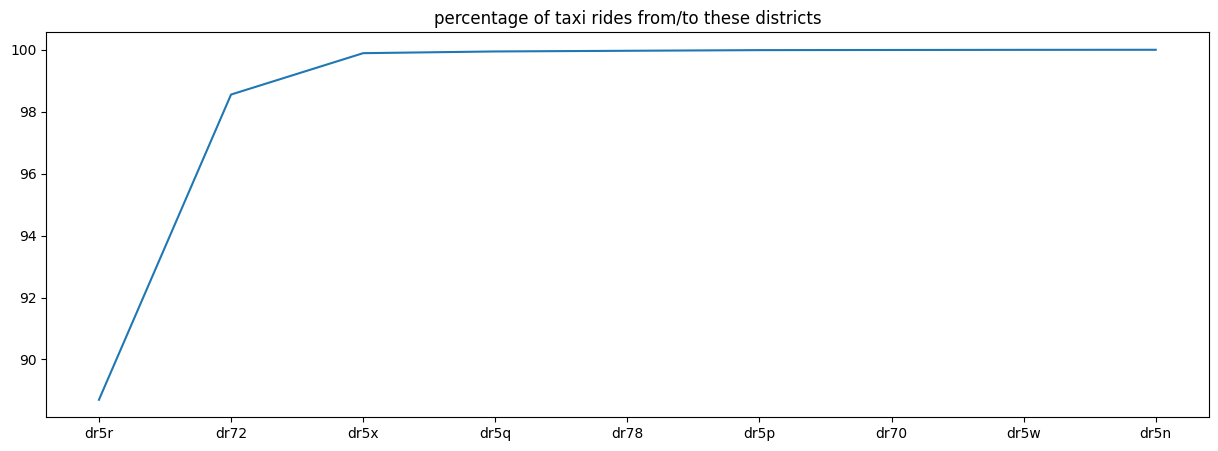

In [77]:
print(len(all_geohashes.value_counts()))
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(all_geohashes.value_counts()[:20])/(2*len(X_train))*100)
plt.title("percentage of taxi rides from/to these districts");


☝️ Sadece ilk 20 bölge önemli. Bunları one-hot kodlayabiliriz.

In [78]:
most_important_geohash_districts = np.array(all_geohashes.value_counts()[:20].index)
most_important_geohash_districts


array(['dr5r', 'dr72', 'dr5x', 'dr5q', 'dr78', 'dr5p', 'dr70', 'dr5w',
       'dr5n'], dtype=object)

In [79]:
# Let's hard-code below the 20 most frequent district GeoHashes of precision 5,
# covering about 99% of all dropoff/pickup locations.
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]


Her GeoHash'i yukarıda listelenen ilk 20 farklı kovadan birinde one-hot kodlayalım

In [80]:
geohash_categories = [
    most_important_geohash_districts,  # pickup district list
    most_important_geohash_districts  # dropoff district list
]

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse_output=False
    )
)
geohash_pipe


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function compute_geohash at 0x7859d5ec88b0>)),
                ('onehotencoder',
                 OneHotEncoder(categories=[['dr5ru', 'dr5rs', 'dr5rv', 'dr72h',
                                            'dr72j', 'dr5re', 'dr5rk', 'dr5rz',
                                            'dr5ry', 'dr5rt', 'dr5rg', 'dr5x1',
                                            'dr5x0', 'dr72m', 'dr5rm', 'dr5rx',
                                            'dr5x2', 'dr5rw', 'dr5rh',
                                            'dr5x8'],
                                           ['dr5ru', 'dr5rs', 'dr5rv', 'dr72h',
                                            'dr72j', 'dr5re', 'dr5rk', 'dr5rz',
                                            'dr5ry', 'dr5rt', 'dr5rg', 'dr5x1',
                                            'dr5x0', 'dr72m', 'dr5rm', 'dr5rx',
                                            'dr5x2', 'dr5rw', 'dr5rh',
                                            'dr5x8']],
                               handle_unknown='ignore', sparse_output=False))])

## 3.5) Tam Ön İşleme Pipeline'ı

Son ön işlemcimizi özetleyelim

### a) Kodlayıcılar

In [81]:
import math
import numpy as np
import pandas as pd
import pygeohash as gh


In [82]:
def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    timedelta = (X["pickup_datetime"] - pd.Timestamp('2009-01-01T00:00:00', tz='UTC'))/pd.Timedelta(1,'D')

    pickup_dt = X["pickup_datetime"].dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)

    return np.stack([hour_sin, hour_cos, dow, month, timedelta], axis=1)


In [83]:
def transform_lonlat_features(X: pd.DataFrame) -> pd.DataFrame:

    assert isinstance(X, pd.DataFrame)
    lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

    def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
        """
        Calculate the haversine and Manhattan distances between two points on the earth (specified in decimal degrees).
        Vectorized version for pandas df
        Computes distance in Km
        """
        earth_radius = 6371

        lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
        lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

        dlon_rad = lon_2_rad - lon_1_rad
        dlat_rad = lat_2_rad - lat_1_rad

        manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
        manhattan_km = manhattan_rad * earth_radius

        a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
        haversine_rad = 2 * np.arcsin(np.sqrt(a))
        haversine_km = haversine_rad * earth_radius

        return dict(
            haversine=haversine_km,
            manhattan=manhattan_km)

    result = pd.DataFrame(distances_vectorized(X, *lonlat_features))

    return result


In [84]:
def compute_geohash(X: pd.DataFrame, precision: int = 5) -> np.ndarray:
    """
    Add a GeoHash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up, and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]


### b) Pipeline

In [85]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer


In [86]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p - p_min) / (p_max - p_min))

# DISTANCE PIPE
dist_min = 0
dist_max = 100

distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
)

# TIME PIPE
timedelta_min = 0
timedelta_max = 2090

time_categories = [
    np.arange(0, 7, 1),  # days of the week
    np.arange(1, 13, 1)  # months of the year
]

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2,3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - timedelta_min) / (timedelta_max - timedelta_min)), [4]), # min-max scale the columns 4 ["timedelta"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

# GEOHASH PIPE
lonlat_features = [
    "pickup_latitude", "pickup_longitude", "dropoff_latitude",
    "dropoff_longitude"
]

# Below are the 20 most frequent district geohashes of precision 5,
# covering about 99% of all dropoff/pickup locations,
# according to prior analysis in a separate notebook
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

geohash_categories = [
    most_important_geohash_districts,  # pickup district list
    most_important_geohash_districts  # dropoff district list
]

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse_output=False
    )
)

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
        ("geohash", geohash_pipe, lonlat_features),
    ],
    n_jobs=-1,
)


In [87]:
final_preprocessor


ColumnTransformer(n_jobs=-1,
                  transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x785a1c32e5f0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x785a1c32d090>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformer...
                                                                             'dr5x0',
                                                                             'dr72m',
                                                                             'dr5rm',
                                                                             'dr5rx',
                                                                             'dr5x2',
                                                                             'dr5rw',
                                                                             'dr5rh',
                                                                             'dr5x8'],
                                                                            ['dr5ru',
                                                                             'dr5rs',
                                                                             'dr5rv',
                                                                             'dr72h',
                                                                             'dr72j',
                                                                             'dr5re',
                                                                             'dr5rk',
                                                                             'dr5rz',
                                                                             'dr5ry',
                                                                             'dr5rt',
                                                                             'dr5rg',
                                                                             'dr5x1',
                                                                             'dr5x0',
                                                                             'dr72m',
                                                                             'dr5rm',
                                                                             'dr5rx',
                                                                             'dr5x2',
                                                                             'dr5rw',
                                                                             'dr5rh',
                                                                             'dr5x8']],
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

In [88]:
final_preprocessor.fit(X_train)

X_train_processed = final_preprocessor.transform(X_train)
X_val_processed = final_preprocessor.transform(X_val)
X_test_processed = final_preprocessor.transform(X_test)


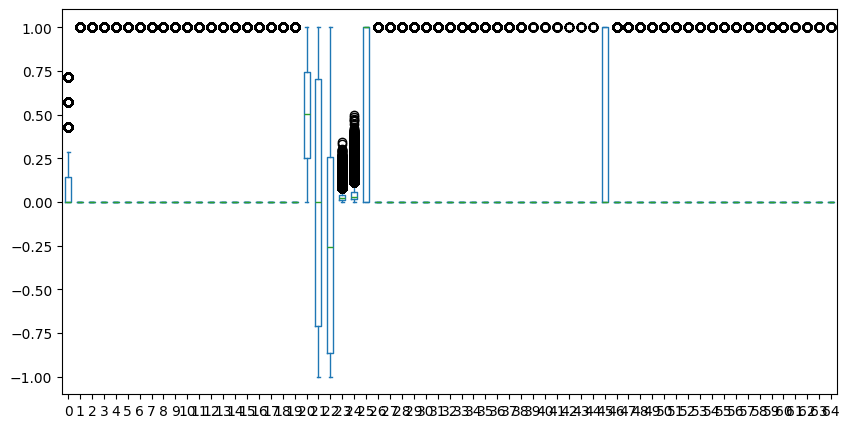

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);


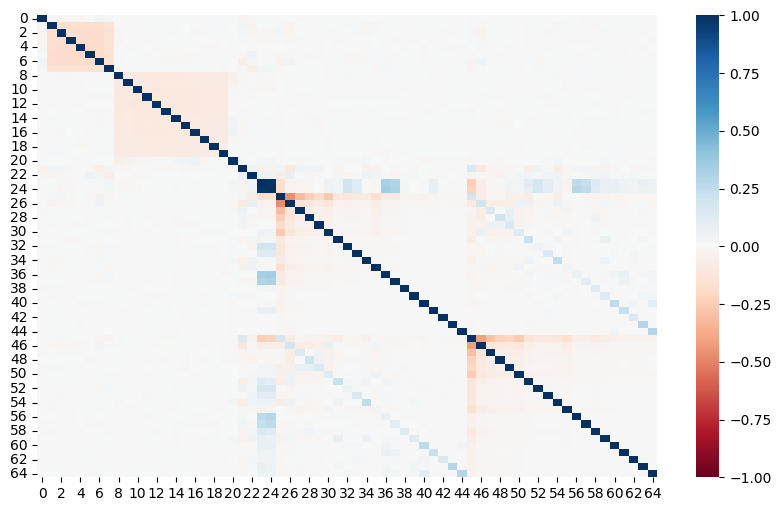

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');


Sonuç olarak, çok fazla performans kaybetmeden işlenmiş verimizi muhtemelen float32'ye de sıkıştırabiliriz

In [91]:
X_train_processed.dtype


dtype('float64')

In [92]:
print(X_train_processed.nbytes / 1024**2, "MB")


42.09388732910156 MB


In [93]:
# Compress the data a bit
X_train_processed = X_train_processed.astype(np.float32)
X_val_processed = X_val_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)

print(X_train_processed.nbytes / 1024**2, "MB")


21.04694366455078 MB


In [94]:
pd.DataFrame(X_train_processed)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.571429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.571429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.571429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84877,0.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84878,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84879,0.714286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84880,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
pd.DataFrame(X_train_processed).describe().mean(axis=1)


count    84882.000000
mean         0.068347
std          0.203538
min         -0.030769
25%         -0.019855
50%          0.019938
75%          0.060780
max          0.977890
dtype: float64

☝️ Ön işlemci eğitim kümesinden bağımsız **sabit** sayıda özellik (65) çıkarır. 

☝️ Ön işlemci aynı zamanda **durumsuz**dur (yani `.fit()` metodu yoktur, yalnızca `.transform()` vardır). Bu, standart ölçeklemenin aksine, "X_train standart sapmaları"nı iç durumlar olarak saklamak zorunda olan saf bir fonksiyon $f:X \rightarrow X_{processed}$ olarak görülebilir.

Bu iki özellik, ML Mühendisliği ekibinin ön işlemeyi yüzlerce GB'lara ölçeklendirmek için işlerini çok daha kolay hale getirecektir.

# 4) Model

## 4.1) Mimari

In [96]:
from tensorflow import keras
from keras import Model, Sequential, layers, regularizers
from keras.callbacks import EarlyStopping


2026-02-02 19:18:34.923162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 19:18:35.826307: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 19:18:36.085966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-02 19:18:36.085995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [97]:
def initialize_model(input_shape:tuple) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l1=0.005)

    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.9))  # use momentum=0 to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model


In [98]:
model = initialize_model(input_shape=X_train_processed.shape[1:])
model.summary()


✅ model initialized
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               6600      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 

2026-02-02 19:18:41.661634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-02 19:18:41.662809: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-02 19:18:41.662835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SELEN): /proc/driver/nvidia/version does not exist
2026-02-02 19:18:41.666617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [99]:
learning_rate = 0.0005
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])


In [100]:
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

history = model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
332/332 [==============================] - 3s 5ms/step - loss: 146.6453 - mae: 9.9156 - val_loss: 84.8144 - val_mae: 7.4701
Epoch 2/100
332/332 [==============================] - 1s 3ms/step - loss: 58.9029 - mae: 5.7796 - val_loss: 31.1393 - val_mae: 3.4597
Epoch 3/100
332/332 [==============================] - 2s 5ms/step - loss: 27.9267 - mae: 3.0662 - val_loss: 21.4093 - val_mae: 2.6451
Epoch 4/100
332/332 [==============================] - 1s 4ms/step - loss: 24.1414 - mae: 2.7514 - val_loss: 20.8567 - val_mae: 2.6552
Epoch 5/100
332/332 [==============================] - 1s 3ms/step - loss: 22.8899 - mae: 2.6437 - val_loss: 19.9539 - val_mae: 2.6035
Epoch 6/100
332/332 [==============================] - 1s 4ms/step - loss: 22.2100 - mae: 2.5668 - val_loss: 19.8519 - val_mae: 2.6149
Epoch 7/100
332/332 [==============================] - 1s 3ms/step - loss: 21.5947 - mae: 2.5049 - val_loss: 19.4435 - val_mae: 2.4230
Epoch 8/100
332/332 [==============================] -

## 4.2) Performans değerlendirmesi

In [101]:
print("MAE val", round(model.evaluate(X_val_processed, y_val)[1],2), ' $')
print("MAE test", round(model.evaluate(X_test_processed, y_test)[1],2), ' $')
print("MAE test baseline", round(float(baseline_mae_test),2), ' $')


55/55 [==============================] - 0s 2ms/step - loss: 17.3994 - mae: 2.3746
MAE val 2.37  $
56/56 [==============================] - 0s 1ms/step - loss: 18.1676 - mae: 2.5266
MAE test 2.53  $
MAE test baseline 2.88  $


In [102]:
y_pred = model.predict(X_test_processed)


56/56 [==============================] - 0s 1ms/step


(0.0, 60.0)

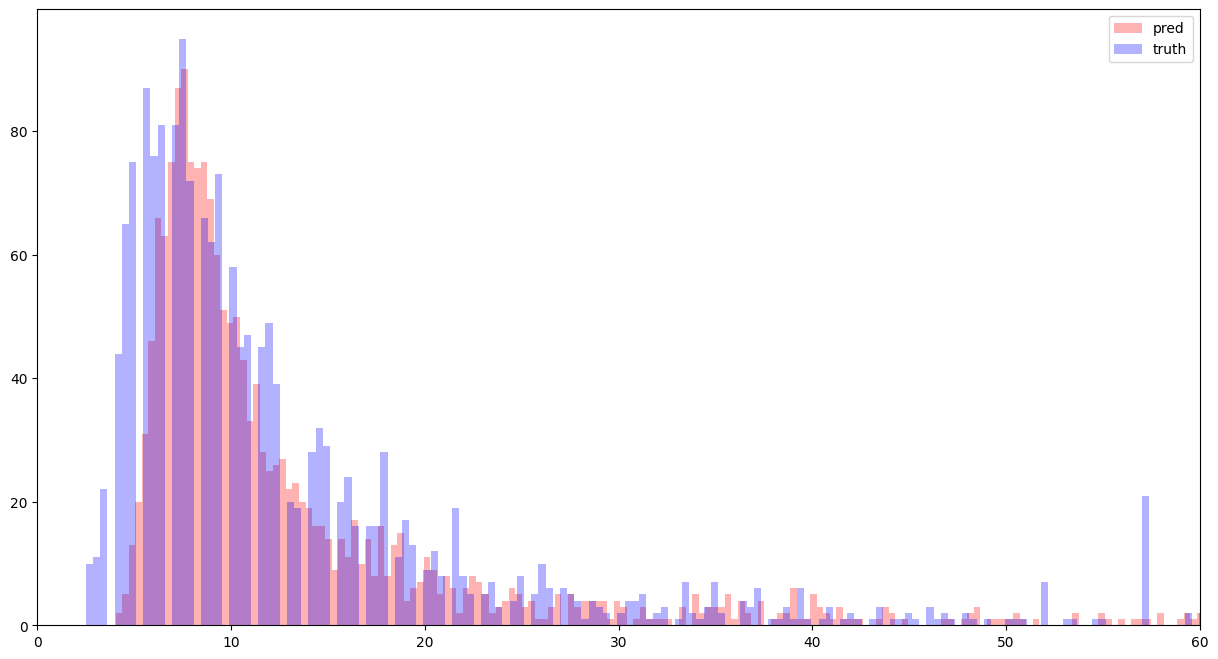

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)

plt.legend()
plt.xlim((0,60))


In [104]:
residuals = y_pred - y_test


In [105]:
residuals.describe()


,fare_amount
count,1767.000000
mean,0.320693
std,4.022181
min,-44.452953
25%,-0.839649
50%,0.893757
75%,2.121670
max,24.686863


(-20.0, 20.0)

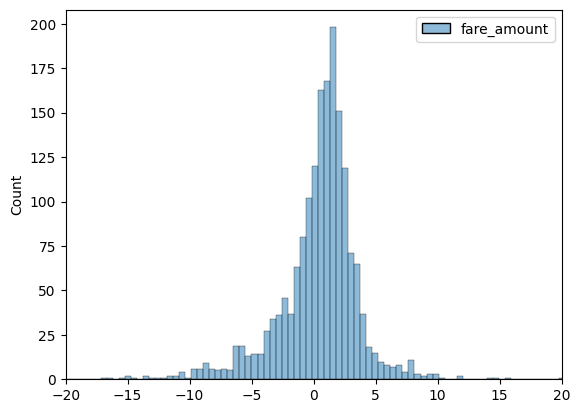

In [106]:
residuals = y_pred - y_test
sns.histplot(residuals)
plt.xlim(xmin=-20, xmax=20)


In [107]:
residuals.sort_values(by='fare_amount')


,fare_amount
89183,-44.452953
90031,-43.215233
90270,-32.785881
90513,-30.945005
89595,-29.413849
...,...
90561,14.583233
88989,15.893631
89996,20.145109
89108,22.183367


Text(0, 0.5, 'residuals')

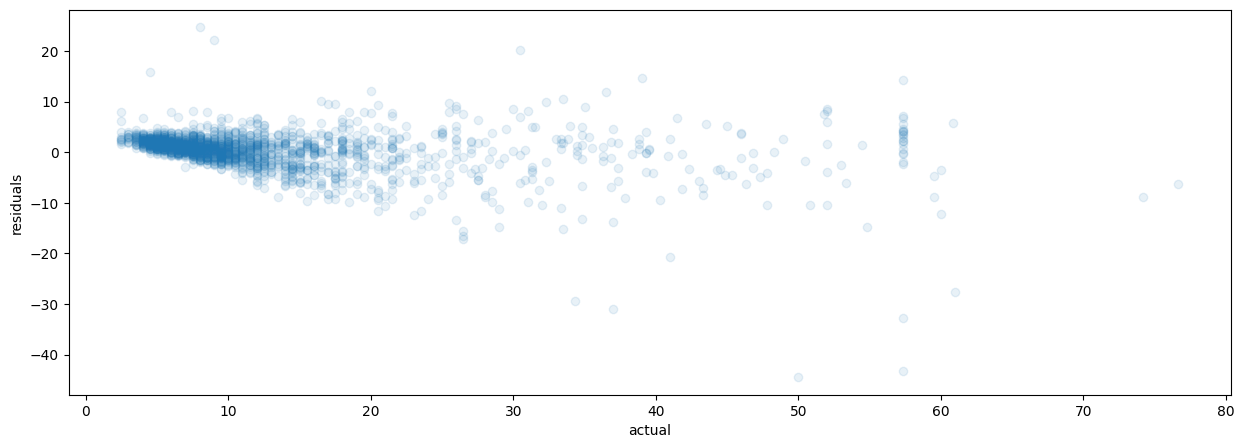

In [108]:
# Residual vs. actual scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=residuals, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('residuals')


Text(0, 0.5, 'residuals')

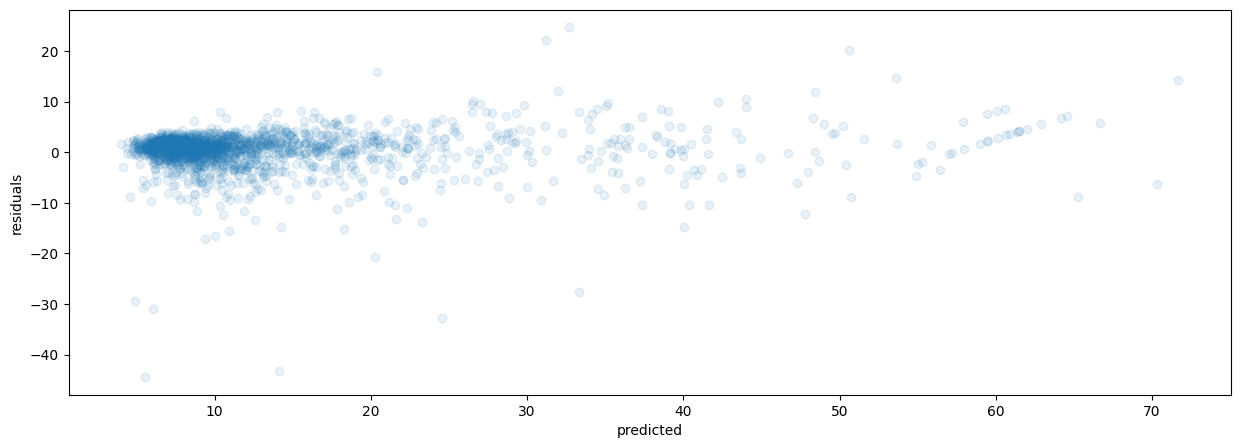

In [109]:
# Residual vs. predicted scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_pred,y=residuals, alpha=0.1)
plt.xlabel('predicted')
plt.ylabel('residuals')


☝️ Sınırlı 60k veri seti üzerinde eğitilen modelimizin ortalama yolculuk fiyatı 11$'a kıyasla yolculuk başına yaklaşık 2.5$ MAE'si var.  

Basit bir doğrusal regresyon bize yaklaşık 3$ MAE verir, ama şeytan ayrıntılarda gizlidir!

Özellikle, çok uzun/pahalı yolculukları tahmin etmede o kadar iyi değiliz.

# 🧪 Anlayışınızı Test Edin

❓ Arkadaşınızla bu soruları cevaplamaya çalışın
1. Modelin performansından memnun musunuz? 
2. Geliştirmek için herhangi bir fikirler?
3. Durumsuz pipeline nedir (durumlu olanın aksine)?
4. OHEncoder sabit sütun kategorileri ile nasıl çalışır?
5. Sinir Ağında veri normalleştirme nasıl yapılır?

<details>
  <summary markdown='span'>💡 Cevaplar</summary>

1. Doğrusal regresyon temeline göre %25 iyileşmemiz var (ama emin olmak için bunu çapraz doğrulamamız gerekir). Ayrıca, fiyatları trafiğe de bağlı olan taksi yolculuklarında 2$'lık tahmin hatası indirgenemez hata oranına yakın görünüyor.


2. Daha fazla eğitim verisi ekleyerek modeli geliştirebiliriz (bunu daha sonra test edeceğiz). Başka bir umut verici fikir kategorik özelliklerimizin gömülmesini *öğrenmek* olabilir (onları one-hot kodlamak yerine).


3. Durumsuz pipeline gerçek bir `.fit()` metoduna sahip değildir, yalnızca `.transform()` vardır. 


4. Durumsuz olmak için, one-hot kodlanacak `kategorileri` sabit kodladık `OneHotEncoder(categories=categories,...)` ve ölçekleyicilerimizde her sütunun istatistiksel özelliklerini sabit kodladık:  `FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))`


5. TensorFlow modelinde, her yoğun katman arasına eklediğimiz `layers.BatchNormalization()`'ı fark edin, bu da verileri batch-per-batch normalleştirir! Geri yayılım sırasında gradyan kaybolmasını düzeltmeye yardımcı olan harika bir özelliktir!


</details>

❓ Aşağıdaki bu yeni yolculuk `X_new` için fiyat tahmin edin ve sonucu `y_new` olarak `np.ndarray` şeklinde saklayın

In [110]:
X_train.iloc[0:2,:]['pickup_datetime']


53627   2012-07-01 15:50:45+00:00
25227   2010-09-09 19:19:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [111]:
X_new = pd.DataFrame(dict(
    pickup_datetime=[pd.Timestamp("2013-07-06 17:18:00", tz='UTC')],
    pickup_longitude=[-73.950655],
    pickup_latitude=[40.783282],
    dropoff_longitude=[-73.984365],
    dropoff_latitude=[40.769802],
    passenger_count=[1],
))

X_new


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-07-06 17:18:00+00:00,-73.950655,40.783282,-73.984365,40.769802,1


In [116]:
y_new = model.predict(X_test_processed[:1])

1/1 [==============================] - 0s 25ms/step


In [117]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'notebook',
    subdir='train_at_scale',
    y_new=y_new
)

result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-9.0.2, pluggy-1.6.0 -- /home/selen/.pyenv/versions/taxifare-env/bin/python
cachedir: .pytest_cache
rootdir: /home/selen/data/S20D1-S-data-train-at-scale/tests
configfile: pytest.ini
collecting ... collected 1 item

test_notebook.py::TestNotebook::test_y_pred PASSED

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/train_at_scale/notebook.pickle

git commit -m 'Completed notebook step'

git push origin master



Son olarak, Kitt'in ilerlemenizi takip edebilmesi için `make test_kitt` çalıştıralım

In [118]:
! cd .. && make test_kitt



 🧪 computing and saving your progress at 'tests/train_at_scale/test_output.txt'...(this can take a while)

 🙏 Please: 
 git add tests 
 git commit -m 'checkpoint' 
 ggpush
